# Predict stop sign heading
Goal of this project is to predict the heading (in degrees) of the stop sign (relative to the camera)

## All the imports

In [1]:
import os
import cv2
import numpy as np
import sklearn
import random

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation, Dropout
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Cropping2D, AveragePooling2D
from keras import backend as K
from sklearn.model_selection import train_test_split

import texttable as tt
from matplotlib import pyplot as plt
from keras.utils import np_utils

Using TensorFlow backend.


## Data Augmentation (If needed) 

In [2]:
# just in case if needed for Data Augmentation
def change_brightness(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv)

    value = random.randint(-10, 10)
    if (value > 0):
        lim = 255 - value
        v[v > lim] = 255
        v[v <= lim] += value
    else:
        lim = -value
        v[v < lim] = 0
        v[v >= lim] -= lim

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2RGB)
    return img

def rotate_image(img):
    rows, cols, ch = img.shape

    M = cv2.getRotationMatrix2D((cols/2, rows/2), random.uniform(-5, 5), 1)
    dst = cv2.warpAffine(img, M, (cols,rows))
    return dst

## Split data into Train, validation, and test set
We have 4830 images for training, validation, and testing. The image set spans the range of [-80, 80] degrees of heading at increment of 1 degree, with 30 images sampled at each heading. Stop sign has a relative heading of 0 degrees, when it is directly facing the camera. Below are some samples of data

65 degrees | -65 degrees | 30 degrees | -30 degrees
- | - | - | - 
![alt](images/sign_65_4.jpg) | ![alt](images/sign_-65_4.jpg) | ![alt](images/sign_30_4.jpg) | ![alt](images/sign_-30_4.jpg)

In [3]:
data_dir = './images/'
samples = sklearn.utils.shuffle(os.listdir(data_dir))

train, test_samples = train_test_split(samples, test_size=0.2)
train_samples, validation_samples = train_test_split(train, test_size=0.2)

print("Number of Training Samples: ", len(train_samples))
print("Number of Validation Samples: ", len(validation_samples))
print("Number of Test Samples: ", len(test_samples))

Number of Training Samples:  3091
Number of Validation Samples:  773
Number of Test Samples:  966


## Data generator to handle large datasets 

In [4]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        samples = sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            heading = []
            for batch_sample in batch_samples:
                name = data_dir + batch_sample
                image = cv2.cvtColor(cv2.imread(name),cv2.COLOR_BGR2RGB)
                images.append(image)
                heading.append(float(batch_sample.split('_')[1]))

            x_train = np.array(images)
            y_train = np.array(heading)
            yield x_train, y_train

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)
test_generator = generator(test_samples, batch_size=32)

## Train the network 

In [5]:
model = Sequential()

model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(275,275,3)))

model.add(Convolution2D(24, 3, 3, border_mode='same', subsample=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(36, 3, 3, border_mode='same', subsample=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(48, 3, 3, border_mode='same', subsample=(2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(20, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# Train the model
model.fit_generator(train_generator,
                    samples_per_epoch= len(train_samples),
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples),
                    nb_epoch=4)

Epoch 1/4
3091/3091 [==============================] - 4s - loss: 718.9587 - val_loss: 5.2774

## Mean squared error on test images

In [6]:
# Find MSE on the testing dataset
model.evaluate_generator(test_generator, val_samples=len(test_samples))

2.8020232160639318

In [14]:
# Only difference between previous cell and the current is
# Here I'm rounding off the floats to nearest integer before
# calculating MSE
# Print the predicted and actual values for each test image
images = []
heading = []
for batch_sample in test_samples:
    name = data_dir + batch_sample
    image = cv2.cvtColor(cv2.imread(name),cv2.COLOR_BGR2RGB)
    images.append(image)
    heading.append(float(batch_sample.split('_')[1]))

x_test = np.array(images)
y_test = np.array(heading)
y_pred = model.predict(x_test)

mse = 0
for i in range(len(y_pred)):
    mse +=  ((y_test[i] - round(y_pred[i][0])) ** 2)
mse /= len(y_pred)
print("mse = ", mse)

tab = tt.Texttable()
headings = ['Image','Predicted','Expected']
tab.header(headings)

for row in zip(test_samples, y_pred, y_test):
    newrow = (row[0], int(row[1][0]), row[2])
    tab.add_row(newrow)

s = tab.draw()
print (s)

mse =  2.86128364389
+-----------------+-----------+----------+
|      Image      | Predicted | Expected |
+=================+===========+==========+
| sign_-80_2.jpg  | -74       | -80      |
+-----------------+-----------+----------+
| sign_6_6.jpg    | 6         | 6        |
+-----------------+-----------+----------+
| sign_29_22.jpg  | 29        | 29       |
+-----------------+-----------+----------+
| sign_-11_28.jpg | -10       | -11      |
+-----------------+-----------+----------+
| sign_-18_15.jpg | -15       | -18      |
+-----------------+-----------+----------+
| sign_19_10.jpg  | 19        | 19       |
+-----------------+-----------+----------+
| sign_-52_22.jpg | -53       | -52      |
+-----------------+-----------+----------+
| sign_-33_8.jpg  | -29       | -33      |
+-----------------+-----------+----------+
| sign_71_8.jpg   | 70        | 71       |
+-----------------+-----------+----------+
| sign_5_15.jpg   | 6         | 5        |
+-----------------+-----------+--

## Visualize the Neural Network's State with Test Images

In [15]:
def get_activations(model, layer_idx, X_batch):
    get_activations = K.function([model.layers[0].input, K.learning_phase()], [model.layers[layer_idx].output,])
    activations = get_activations([X_batch,0])
    return activations

def outputFeatureMap(image_input, layer, model, activation_min=-1, activation_max=-1 ,plt_num=1):
    activation = get_activations(model, layer, np.reshape(image_input, (1, 275, 275, 3)))[0][0]
    featuremaps = activation.shape[2]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[:,:, featuremap], interpolation="nearest", cmap="gray")
    plt.show()

Below are the activations for the following test image

-29 degrees |
- |
![alt](images/sign_-29_12.jpg) |

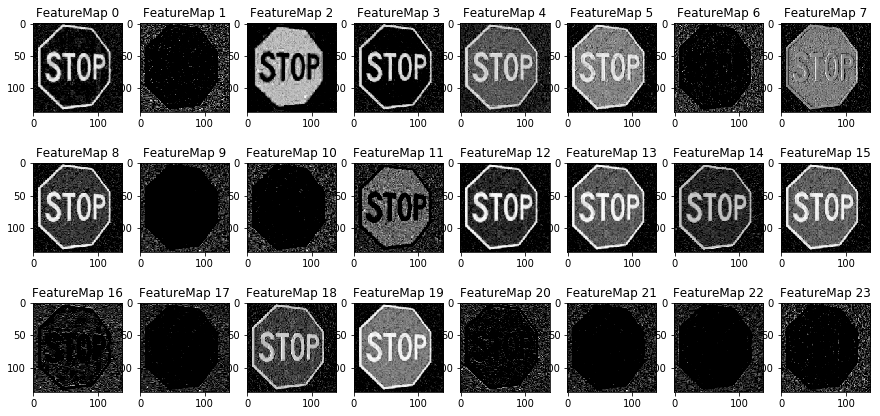

In [16]:
outputFeatureMap(x_test[10], 1, model)

Here understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol. 

Figure above shows 24 feature maps from the first convolutional layer that are looking for edges of Hexagon, letters S, T, O, and P of the traffic sign. Each feature map has a different brighter region, indicating that each of them are looking for differently oriented edges. Feature maps 0, 3, 8, and 12 are looking for edges of Hexagon and letters. Feature maps 4, 5, 7, and 19 Everthing within Hexagon. Feature map 0 and feature map 11 are complements of each other where both are extracting the contrast between the background and foreground of the traffic sign. This shows that the network has learned to look for interesting charecterstics of a traffic sign.